##### Copyright 2022 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# Image aesthetic scoring with MUSIQ models

In this colab, you can try any of the 4 [MUSIQ](https://ai.googleblog.com/2022/10/musiq-assessing-image-aesthetic-and.html) models to score the aesthetic of an image.

These models have a specific characteristic that it can handle images in any size or aspect ratio, making it not necessary to do any preprocessing on the image


In [2]:
import tensorflow as tf
import tensorflow_hub as hub

import requests
from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

# Load Model

In [3]:
selected_model = 'koniq' #@param ['spaq', 'koniq', 'paq2piq', 'ava']

NAME_TO_HANDLE = {
    # Model trained on SPAQ dataset: https://github.com/h4nwei/SPAQ
    'spaq': 'https://tfhub.dev/google/musiq/spaq/1',

    # Model trained on KonIQ-10K dataset: http://database.mmsp-kn.de/koniq-10k-database.html
    'koniq': 'https://tfhub.dev/google/musiq/koniq-10k/1',

    # Model trained on PaQ2PiQ dataset: https://github.com/baidut/PaQ-2-PiQ
    'paq2piq': 'https://tfhub.dev/google/musiq/paq2piq/1',

    # Model trained on AVA dataset: https://ieeexplore.ieee.org/document/6247954
    'ava': 'https://tfhub.dev/google/musiq/ava/1',
}

model_handle = NAME_TO_HANDLE[selected_model]
model = hub.load(model_handle)
predict_fn = model.signatures['serving_default']

print(f'loaded model {selected_model} ({model_handle})')

loaded model koniq (https://tfhub.dev/google/musiq/koniq-10k/1)


# Util functions

Functions to download an image and to show it.

In [4]:
def load_image_from_url(img_url):
  """Returns an image with shape [1, height, width, num_channels]."""
  user_agent = {'User-agent': 'Colab Sample (https://tensorflow.org)'}
  response = requests.get(img_url, headers=user_agent)
  print(response.content)
  image_bytes = BytesIO(response.content)
  image = Image.open(image_bytes)
  return image, response.content

def show_image(image, title=''):
  image_size = image.size
  plt.imshow(image)
  plt.axis('on')
  plt.title(title)
  plt.show()

# Load an image

The prediction will run directly on the bytes loaded, no preprocessing is needed

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x03\x00\x08\x02\x00\x00\x005\xd8\x82Z\x00\x00\n\xa9iCCPicc\x00\x00H\x89\x95\x97\x07TS\xd9\x16\x86\xcf\xbd\xe9!!@B\x95\x12z\x93\xde\x02H\t=\x80\x82t\x10\x95\x90\x04\x08%\x84@hvdp\x04\xc6\x82\x88\x08Vt\x04D\xc1\xb1\x002\x8a\x8a(\x16DQ\x01\x0b: \x83\x822\x0e\x16\xb0`y\x17X\x84\x99y\xeb\xbd\xb7\xde\xce:k\x7f\xeb\xcf>\xfb\x9c}\xd6=w\xed\x0b\x00Y\x86-\x14&\xc32\x00\xa4\x082DA\xden\xf4\x88\xc8(:\xee9  ?<\xb0\x04d6\']\xc8\x0c\x0c\xf4\x07\x88\xcd\xf9\xbf\xdbd/\x80\xa6\xfd=\x93\xe9\\\xff\xfe\xff\x7f5Y./\x9d\x03\x00\x14\x88p,7\x9d\x93\x82\xf0id\xbc\xe4\x08E\x19\x00\xa0\x0e \xbavV\x86p\x9a\xdb\x11\xa6\x89\x90\r"\xfc`\x9a\xe3gyl\x9acg\x18\rfbB\x82\xdc\x11\xa6\x01\x80\'\xb1\xd9\xa2x\x00HtD\xa7gr\xe2\x91<$W\x84\xcd\x05\\\xbe\x00a!\xc2\xce))\xa9\\\x84O l\x80\xc4 \x1ai:?#\xf6/y\xe2\xff\x963V\x92\x93\xcd\x8e\x97\xf0l-3\x86\xf7\xe0\xa7\x0b\x93\xd99\xff\xe7q\xfcoKI\x16\xcf\xad\xa1\x87\x0cR\x82\xc8\'\x08\xf1r\xc8\x99=HJ\xf5\x93\xb0 vI\xc0\x1c\xf

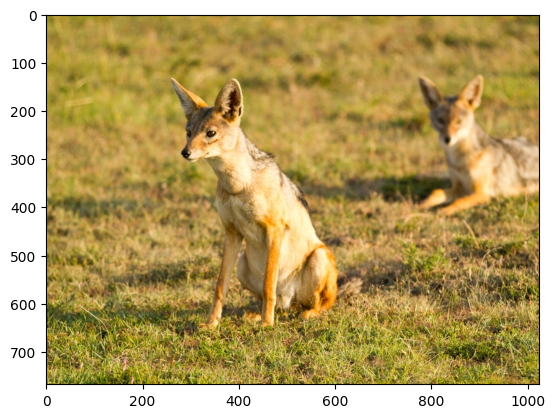

In [5]:
image_url = 'https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEgr0DKaAoO6qTrJo3hXP8UM3D4AB8gQeNI22Q2QphBVGgn-5v84tjhH3ZWTlGtlUoPdlcx54dM93Qi04MuN7eBbj9WlT8Qxy6B2Us4kcn_53FH28MnTtGCzMPhjCVGIgXRL8ZEMeO-7iue7sNEGxBtgx2bI-eKDQAondM8Dfjb1FaybFgUQji4UU9-0vQ/s1024/image9.png' #@param {type: 'string'}

image, image_bytes = load_image_from_url(image_url)

show_image(image)

# Run Prediction on a Single Image

In [17]:
prediction = predict_fn(tf.constant(image_bytes))
print("predicted MOS: ", prediction)
print(prediction['output_0'].numpy())

predicted MOS:  {'output_0': <tf.Tensor: shape=(), dtype=float32, numpy=62.273857>}
62.273857


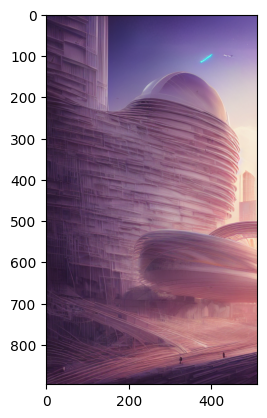

In [8]:
import os

# Load an image from path
image_path = 'part-000001/0a3c75bb-4bd0-47c8-a2ba-e2aee92ad43f.png'

image = Image.open(image_path)
image_bytes = tf.io.read_file(image_path)

show_image(image)


In [18]:
# Save the prediction to a file mapping image id to predicted MOS
with open('predictions.txt', 'w') as f:
  for image_path in os.listdir('part-000001'):
    try:
      image_bytes = tf.io.read_file(os.path.join('part-000001', image_path))
      prediction = predict_fn(tf.constant(image_bytes))
      f.write(f'{image_path},{prediction["output_0"].numpy()}\n')
    except:
      print("Invalid image: ", image_path)

InvalidArgumentError: Graph execution error:

Detected at node 'DecodeJpeg' defined at (most recent call last):
Node: 'DecodeJpeg'
Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]] [Op:__inference_signature_wrapper_25722]